In [8]:
!pip install pyspark  # Install PySpark in Colab


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

# Start a Spark session
spark = SparkSession.builder.appName("CICIDS2017").getOrCreate()


In [10]:
df = spark.read.csv("CICIDS2017.csv", header=True, inferSchema=True)
df.printSchema()  # Show column types
df.show(5)  # Display first 5 rows


root
 |-- Destination Port: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Total Fwd Packets: integer (nullable = true)
 |-- Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |-- Total Length of Bwd Packets: integer (nullable = true)
 |-- Fwd Packet Length Max: integer (nullable = true)
 |-- Fwd Packet Length Min: integer (nullable = true)
 |-- Fwd Packet Length Mean: double (nullable = true)
 |-- Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |-- Bwd Packet Length Min: integer (nullable = true)
 |-- Bwd Packet Length Mean: double (nullable = true)
 |-- Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: string (nullable = true)
 |-- Flow Packets/s: string (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: integer (nullable = true)
 |-- Flow IAT Min: in

Data Preprocessing

In [13]:
#check missing values
# Exclude columns with integer type to avoid the error
# Use '!===' instead of '!=' to compare column types
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns if df.schema[c].dataType.typeName() != 'integer']).show()

+----------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+-----------+------------+-----------+-------------+-------------+------------------+-----------------+----------------------+-------------------+--------------------+--------------------+-----------+----------+---------+--------+-----+
|Fwd Packet Length Mean|Fwd Packet Length Std|Bwd Packet Length Mean|Bwd Packet Length Std|Flow Bytes/s|Flow Packets/s|Flow IAT Mean|Flow IAT Std|Fwd IAT Mean|Fwd IAT Std|Bwd IAT Mean|Bwd IAT Std|Fwd Packets/s|Bwd Packets/s|Packet Length Mean|Packet Length Std|Packet Length Variance|Average Packet Size|Avg Fwd Segment Size|Avg Bwd Segment Size|Active Mean|Active Std|Idle Mean|Idle Std|Label|
+----------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+-----------+------------+-----------+-------------+

In [14]:
df = df.na.fill(0)  # Replace nulls with 0 (modify as needed)


In [15]:
#convert label (attack type) into numeric values
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Label", outputCol="LabelIndex")
df = indexer.fit(df).transform(df)
df.select("Label", "LabelIndex").show(5)


+-----------+----------+
|      Label|LabelIndex|
+-----------+----------+
|   DoS Hulk|       3.0|
|       DDoS|       1.0|
|       DDoS|       1.0|
|   PortScan|       4.0|
|FTP-Patator|       5.0|
+-----------+----------+
only showing top 5 rows



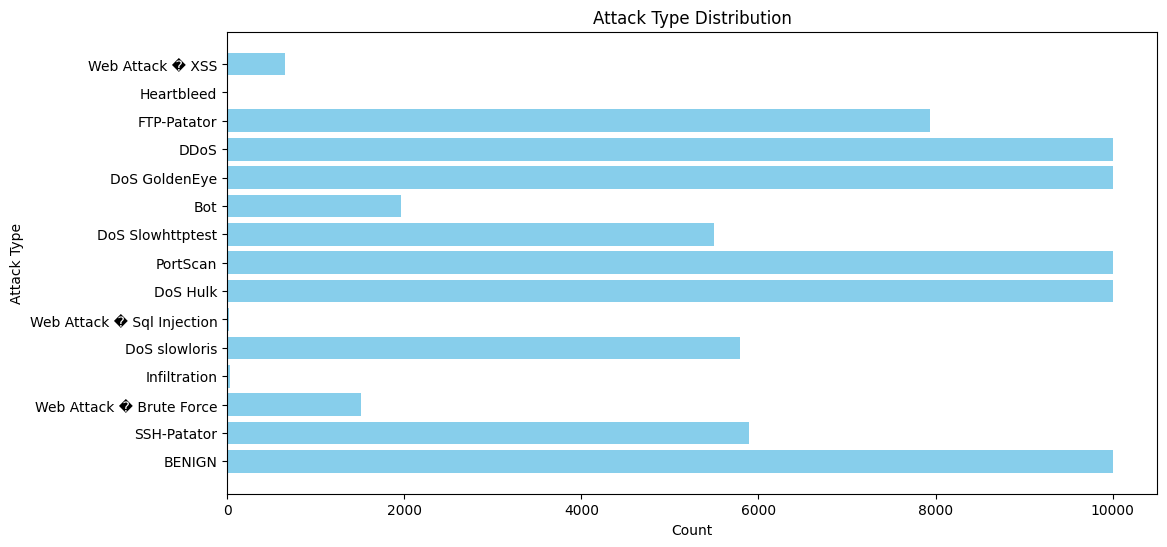

In [16]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas for visualization
pdf = df.groupBy("Label").count().toPandas()

plt.figure(figsize=(12,6))
plt.barh(pdf["Label"], pdf["count"], color="skyblue")
plt.xlabel("Count")
plt.ylabel("Attack Type")
plt.title("Attack Type Distribution")
plt.show()


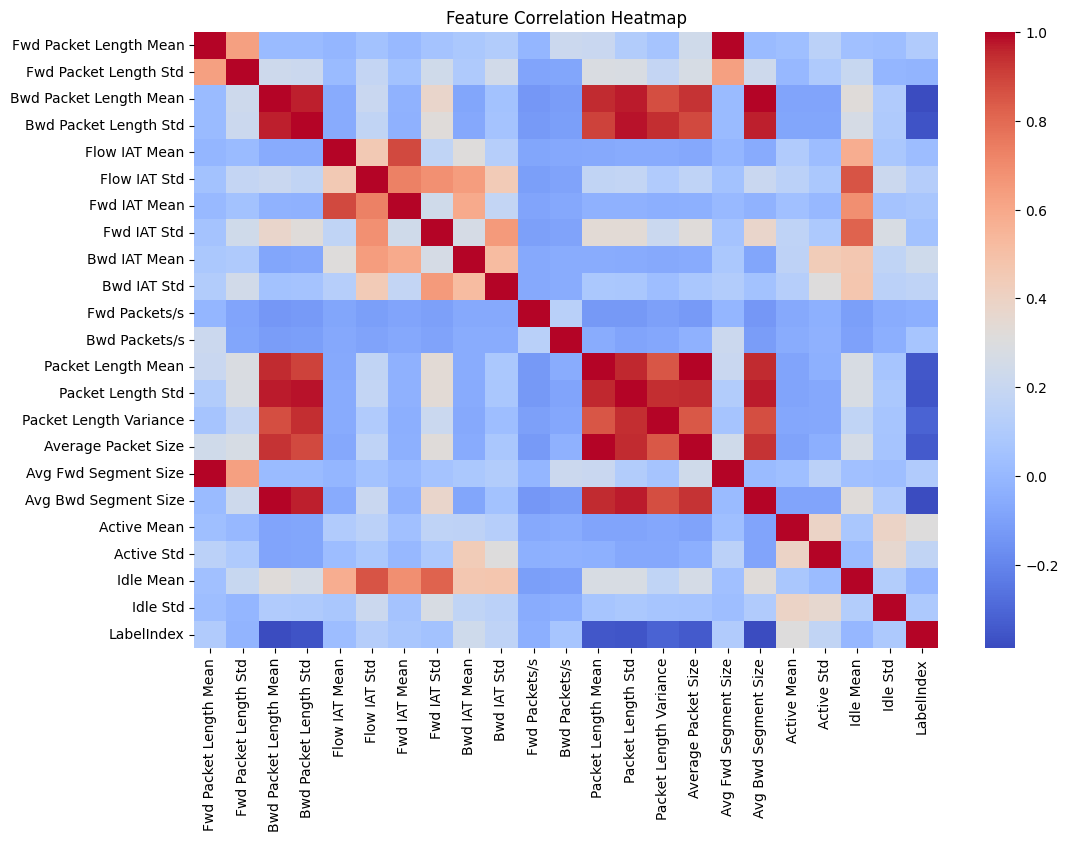

In [18]:
import seaborn as sns
import pandas as pd

# Convert to Pandas for visualization
# Select only numeric columns for correlation calculation
numeric_df = df.select([c for c in df.columns if df.schema[c].dataType.typeName() in ['double', 'float', 'int', 'bigint', 'smallint']]).toPandas()
pdf_corr = numeric_df.corr()


plt.figure(figsize=(12,8))
sns.heatmap(pdf_corr, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [19]:
pdf = df.select(["Label", "Fwd Packet Length Max", "Total Fwd Packets"]).toPandas()


Visualise feature distributions by attack type

<ipython-input-20-0282fb68aca1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=pdf["Label"], order=pdf["Label"].value_counts().index, palette="coolwarm")


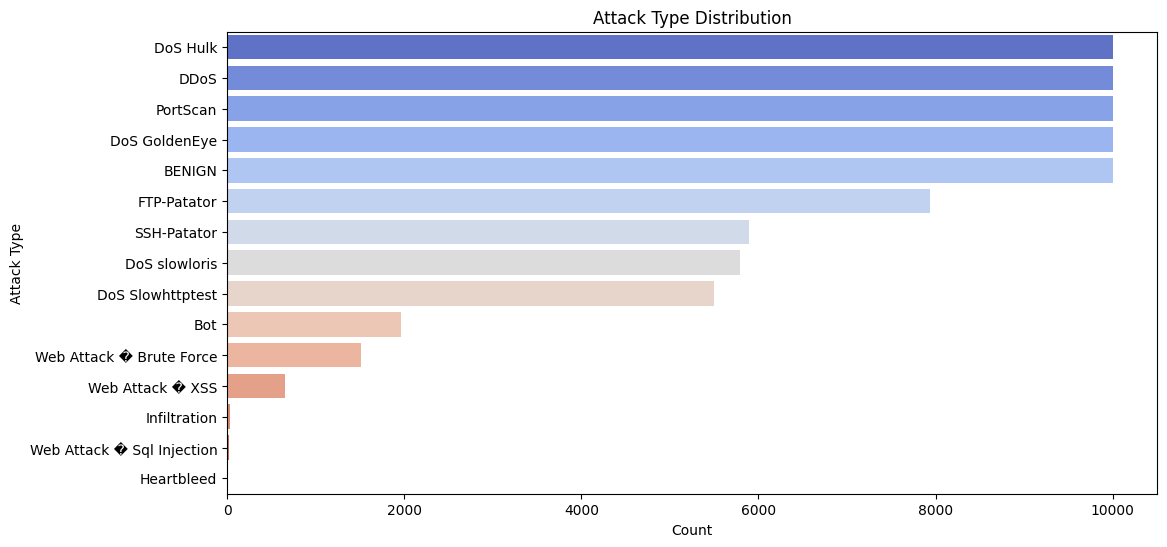

In [20]:
#attack type distribution (bar chart)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(y=pdf["Label"], order=pdf["Label"].value_counts().index, palette="coolwarm")
plt.title("Attack Type Distribution")
plt.xlabel("Count")
plt.ylabel("Attack Type")
plt.show()


<ipython-input-27-98cb60ebfba6>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Attack Type")


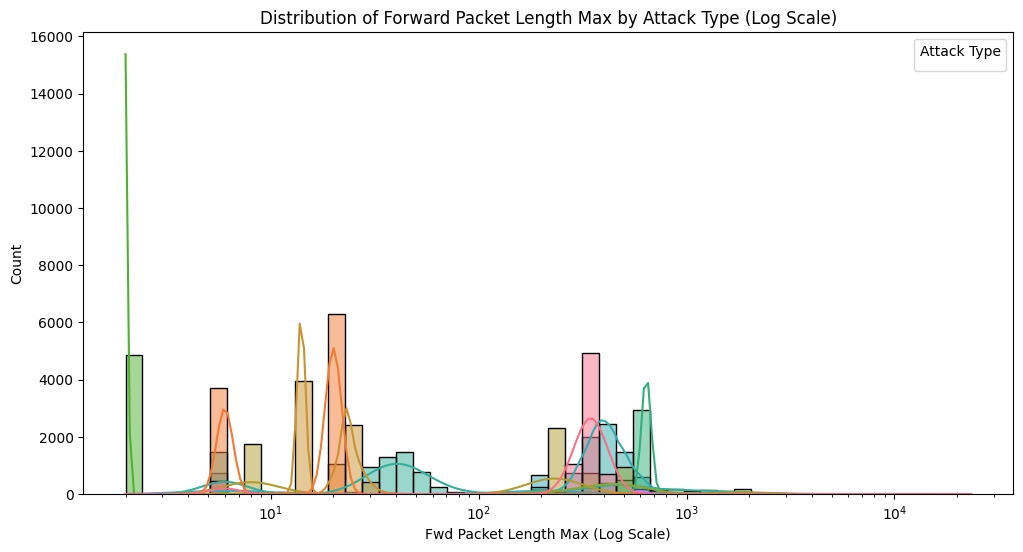

In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# histogram of packet lengths for different attacks
plt.figure(figsize=(12, 6))

# Replace inf and -inf with NaN in all numeric columns
for col in pdf.select_dtypes(include=np.number).columns:
    pdf[col] = pdf[col].replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN in any numeric column
pdf.dropna(subset=pdf.select_dtypes(include=np.number).columns, inplace=True)

# Filter out 0 and negative values before applying log transformation
pdf = pdf[pdf["Fwd Packet Length Max"] > 0]

sns.histplot(data=pdf, x="Fwd Packet Length Max", hue="Label", kde=True, bins=50, log_scale=(True, False))
plt.title("Distribution of Forward Packet Length Max by Attack Type (Log Scale)")
plt.xlabel("Fwd Packet Length Max (Log Scale)")
plt.ylabel("Count")
plt.legend(title="Attack Type")
plt.show()

<ipython-input-29-1814f935f418>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["Label"] = pdf["Label"].astype(str).str.encode("utf-8").str.decode("utf-8")


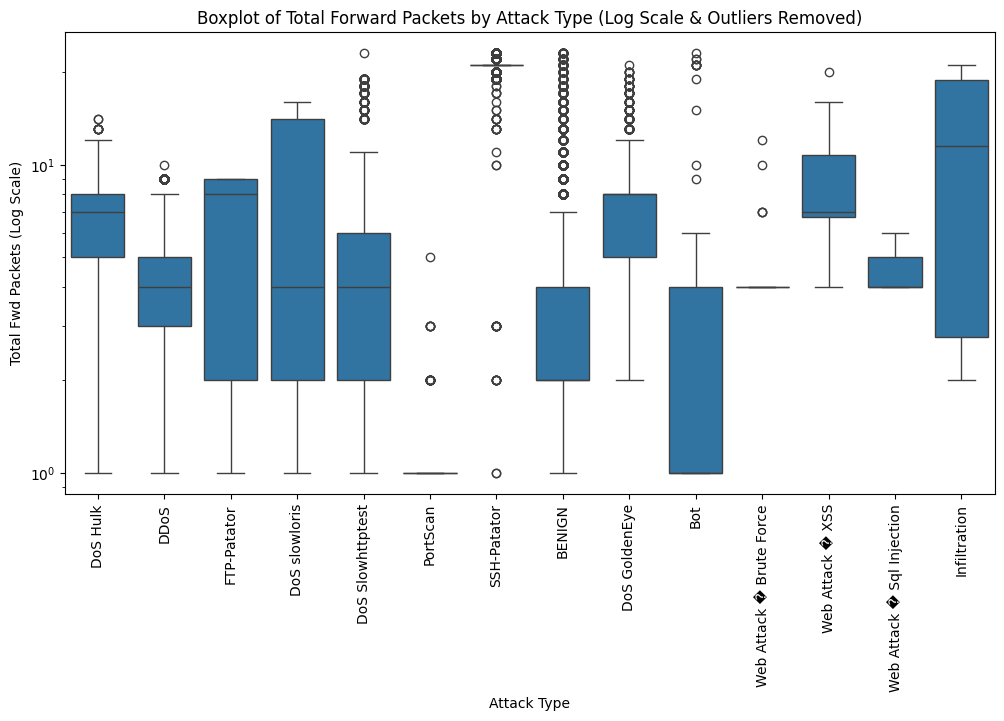

In [29]:
#boxplot for Feature Comparison Across Attacks
import matplotlib.pyplot as plt
import seaborn as sns

# Fix encoding issues in labels
pdf["Label"] = pdf["Label"].astype(str).str.encode("utf-8").str.decode("utf-8")

# Remove extreme outliers (99th percentile filter)
q99 = pdf["Total Fwd Packets"].quantile(0.99)
pdf_filtered = pdf[pdf["Total Fwd Packets"] <= q99]

# Create the boxplot with log scale
plt.figure(figsize=(12,6))
sns.boxplot(x="Label", y="Total Fwd Packets", data=pdf_filtered)
plt.yscale("log")  # Apply log scale
plt.xticks(rotation=90)  # Rotate labels for readability
plt.title("Boxplot of Total Forward Packets by Attack Type (Log Scale & Outliers Removed)")
plt.xlabel("Attack Type")
plt.ylabel("Total Fwd Packets (Log Scale)")
plt.show()



<ipython-input-32-87e90e0a8bd5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["Label"] = pdf["Label"].astype(str).str.encode("utf-8").str.decode("utf-8")
<ipython-input-32-87e90e0a8bd5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["Fwd Packet Length Max"] = np.log1p(pdf["Fwd Packet Length Max"])
<ipython-input-32-87e90e0a8bd5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

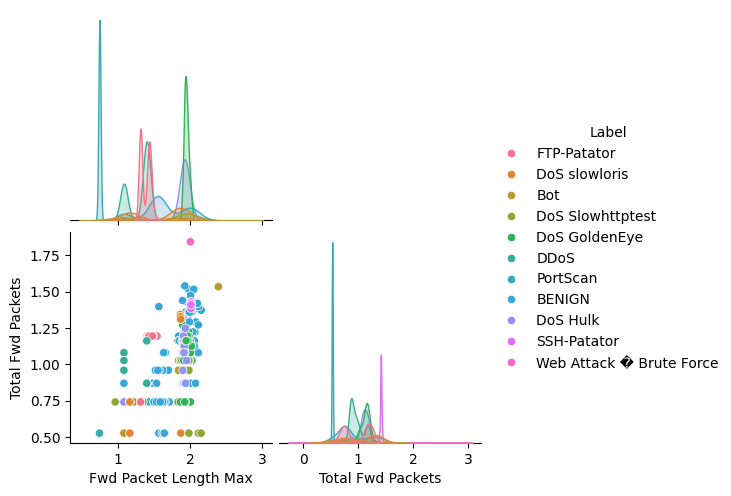

In [32]:
# Pairplot for Feature Relationships
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Fix encoding issues in labels
pdf["Label"] = pdf["Label"].astype(str).str.encode("utf-8").str.decode("utf-8")

# Apply log transformation to make small and large values comparable
pdf["Fwd Packet Length Max"] = np.log1p(pdf["Fwd Packet Length Max"])
pdf["Total Fwd Packets"] = np.log1p(pdf["Total Fwd Packets"])

# Sample to reduce plot clutter
pdf_sample = pdf.sample(1000, random_state=42)  # Reduce to 1000 samples
pdf["Label"] = pdf["Label"].str.replace("�", "")


# Generate pairplot
sns.pairplot(pdf_sample, hue="Label", diag_kind="kde", corner=True)
plt.show()



Test Train Split

In [33]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col

# ✅ Step 1: Initialize Spark Session
spark = SparkSession.builder.appName("CICIDS2017").getOrCreate()

# ✅ Step 2: Convert Pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(pdf)

# ✅ Step 3: Convert Categorical "Label" to Numeric Index
indexer = StringIndexer(inputCol="Label", outputCol="LabelIndex")
df_spark = indexer.fit(df_spark).transform(df_spark)

# ✅ Step 4: Select Features for Model Training
feature_columns = [col for col in df_spark.columns if col not in ["Label", "LabelIndex"]]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_spark = assembler.transform(df_spark).select("features", "LabelIndex")

# ✅ Step 5: Split Data into Train (80%) and Test (20%)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# ✅ Step 6: Print Data Sizes
print(f"Training Data: {train_data.count()} rows")
print(f"Testing Data: {test_data.count()} rows")


Training Data: 46082 rows
Testing Data: 11307 rows


In [35]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.0/681.0 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00


In [37]:
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
import mlflow

# ✅ Step 1: Train Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="LabelIndex", featuresCol="features")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# ✅ Step 2: Train Random Forest Classifier
rf = RandomForestClassifier(labelCol="LabelIndex", featuresCol="features", numTrees=50)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# ✅ Step 3: Train XGBoost Classifier (Using PySpark ML API)
from xgboost.spark import SparkXGBClassifier
xgb = SparkXGBClassifier(label_col="LabelIndex", features_col="features", num_workers=2)
xgb_model = xgb.fit(train_data)
xgb_predictions = xgb_model.transform(test_data)

# ✅ Step 4: Evaluate Models
evaluator = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy")

dt_acc = evaluator.evaluate(dt_predictions)
rf_acc = evaluator.evaluate(rf_predictions)
xgb_acc = evaluator.evaluate(xgb_predictions)

print(f"Decision Tree Accuracy: {dt_acc:.4f}")
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# ✅ Step 5: Log results using MLflow (Optional)
mlflow.log_metric("DecisionTree_Accuracy", dt_acc)
mlflow.log_metric("RandomForest_Accuracy", rf_acc)
mlflow.log_metric("XGBoost_Accuracy", xgb_acc)


INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 15, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


Decision Tree Accuracy: 0.8107
Random Forest Accuracy: 0.8129
XGBoost Accuracy: 0.9043


In [38]:
#Evaluating Model Performance (Precision, Recall, F1-score)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# ✅ Initialize Evaluators
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="recallByLabel")

# ✅ Compute Metrics for Decision Tree
dt_f1 = evaluator_f1.evaluate(dt_predictions)
dt_precision = evaluator_precision.evaluate(dt_predictions)
dt_recall = evaluator_recall.evaluate(dt_predictions)

# ✅ Compute Metrics for Random Forest
rf_f1 = evaluator_f1.evaluate(rf_predictions)
rf_precision = evaluator_precision.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)

# ✅ Compute Metrics for XGBoost
xgb_f1 = evaluator_f1.evaluate(xgb_predictions)
xgb_precision = evaluator_precision.evaluate(xgb_predictions)
xgb_recall = evaluator_recall.evaluate(xgb_predictions)

# ✅ Print Metrics
print(f"📊 Decision Tree - Precision: {dt_precision:.4f}, Recall: {dt_recall:.4f}, F1-score: {dt_f1:.4f}")
print(f"🌲 Random Forest - Precision: {rf_precision:.4f}, Recall: {rf_recall:.4f}, F1-score: {rf_f1:.4f}")
print(f"🚀 XGBoost - Precision: {xgb_precision:.4f}, Recall: {xgb_recall:.4f}, F1-score: {xgb_f1:.4f}")


📊 Decision Tree - Precision: 0.9285, Recall: 0.9864, F1-score: 0.7942
🌲 Random Forest - Precision: 0.9285, Recall: 0.9864, F1-score: 0.7957
🚀 XGBoost - Precision: 0.9645, Recall: 0.9970, F1-score: 0.9036


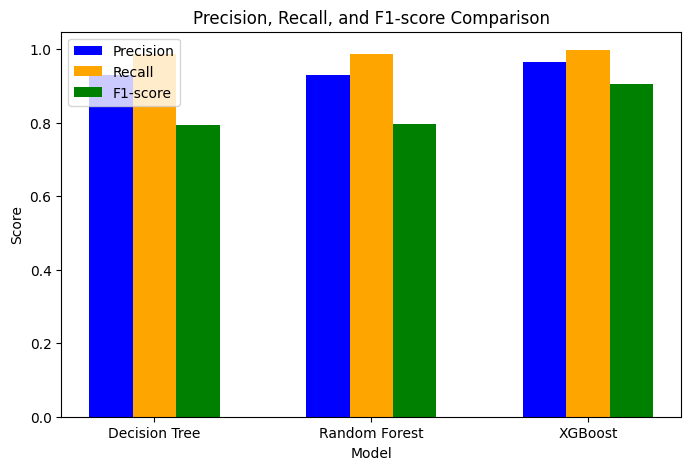

In [39]:
# Draw Test vs. Validation Graph
import matplotlib.pyplot as plt
import numpy as np

# ✅ Define Metrics for Each Model
models = ["Decision Tree", "Random Forest", "XGBoost"]
precision = [dt_precision, rf_precision, xgb_precision]
recall = [dt_recall, rf_recall, xgb_recall]
f1_score = [dt_f1, rf_f1, xgb_f1]

# ✅ Plot Precision, Recall, and F1-score
x = np.arange(len(models))  # Label positions
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width, precision, width, label="Precision", color="blue")
rects2 = ax.bar(x, recall, width, label="Recall", color="orange")
rects3 = ax.bar(x + width, f1_score, width, label="F1-score", color="green")

# ✅ Labels and Formatting
ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("Precision, Recall, and F1-score Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()
